# Investigation and exploitation of the Idoven test dataset




In [1]:
from idoven_data_scientist import analysis

The data is stored in the WFDB format. There is a library available to easily read this data:

https://github.com/MIT-LCP/wfdb-python

This library is able to quickly plot data from the provided datastore:

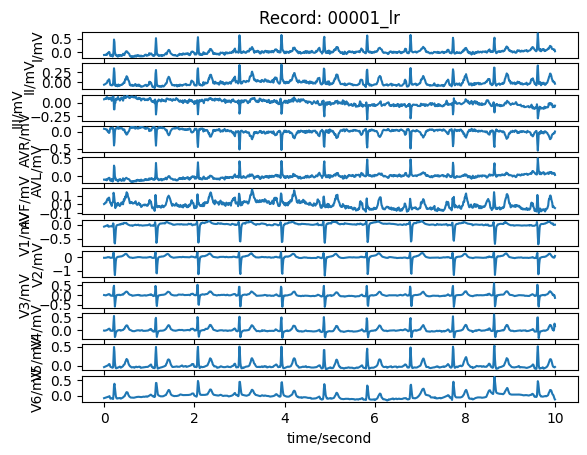

In [2]:
import wfdb

# Records paths are passed without extension:
path = "./data/physionet.org/files/ptb-xl/1.0.2/records100/00000/00001_lr"

record: wfdb.Record = wfdb.rdrecord(path)
wfdb.plot_wfdb(record)

This view already gives an intuition on the nature of the data contained in these ECG files.

Each entry contains 12 recordings of the ECG device.

Checking on: https://en.wikipedia.org/wiki/Electrocardiography, we can see that the signal are functions of the readings in different parts of the patient body:

> Commonly, 10 electrodes attached to the body are used to form 12 ECG leads, with each lead measuring a specific electrical potential difference.

The database also contains descriptor database stored in a csv file, with metadata of all of the recordings.
Using this database we can build a function to easily read and plot the data of each recording, displaying richer information to the users.

I will keep the code in the idoven_data_scientist module instead of adding it all to this notebook, as this makes easy the structuring, testing and later reuse of the code, slowly building a set of tools that can be used (automatically) at a later stage.

We can request plotting any ECG data entry and signal like:

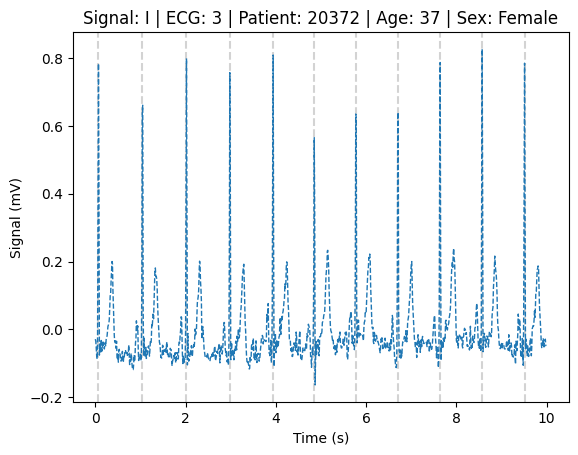

In [3]:
from idoven_data_scientist.analysis import Leads, Freq
analysis.plot_ecg(
    data_path="./data/physionet.org/files/ptb-xl/1.0.2/",
    ecg_id=3,
    lead=Leads.I,
    freq=Freq.LOW,
)

This way, we can easily provide experts a tool to check the data and metadata they require.

As the ECG device provides 12 signals that are highly correlated we can start by preparing de data, firstly signal by signal by:

- Detrending the signals, to remove spourious linear trends. Still, medical experts must be consulted about the significancy of these trends, but for this experiment it will be ignored.
- Recentering the signals at zero, to remove the constant component of the signals.

Also, having 12 of each signals (and actually only 10 free components), we can attempt to clean some of the noise present by performing, for example, a SVD decomposition of the signals matrix and keeping only the most significal singular values:

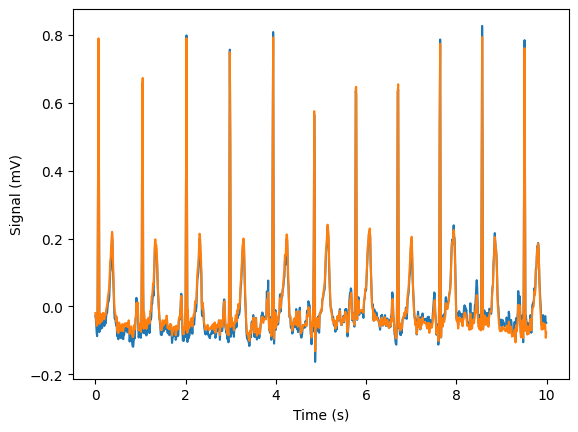

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Firstly we extract the raw signals from the database. This function also provides the corresponding
# ECG database entry, to wich the signals sampling frequency has been added:
ecg_entry, raw_signals = analysis.extract_signals(
    data_path="./data/physionet.org/files/ptb-xl/1.0.2/",
    # Passing "None" we use all the leads:
    leads=None,
    ecg_id=3,
    freq=Freq.LOW,
)
cleaned = analysis.norm_and_denoise(raw_signals, sing_values=4)

x_vals = np.arange(raw_signals.shape[0]) / ecg_entry.frequency
_, ax = plt.subplots()
# Lets print signal (I):
sig_idx = [x._value_ for x in Leads].index(Leads.I._value_)
ax.plot(x_vals, raw_signals[:, sig_idx], label="Raw")
ax.plot(x_vals, cleaned[:, sig_idx], label="Cleaned")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal (mV)")
plt.show()


Now, we will look for the most prominent feature of this data, the frequency of the R peaks, to later find the QRS complex structure in the data around them.

For this, we can use the find_peaks function from scipy.
However, as there is noise and other prominent peaks in the different signals we will, for each of the 12 ECG lead signals:
- Square it, to get positive only values.
- Apply a min/max normalisation to have a more consistent prominence of the peaks.
- Collect the detected peaks.
To avoid counting spurious peaks, as we have 12 signals to count, we will only use the peaks that appear in at least 5 of the signals. This parameter, together with the accepted prominence of the peaks, can be later tweaked either by experts or using cross-validation.

The following function provides the indices of the peaks in the signal and the average frequency of their appearance in the ECG recording:

In [5]:
peaks_idx, peaks_freq = analysis.find_r_frequency(cleaned, ecg_entry.frequency)
peaks_freq

1.1

Finding a frequency of 1.1 peaks/s, or 66 peaks/minute.
The peaks found can be compared with the ECG entry r peaks for validation:

In [9]:
recorded_peaks = analysis.parse_r_peaks_entry(ecg_entry.r_peaks)
print(recorded_peaks)
print(peaks_idx)
assert set(recorded_peaks) == set(peaks_idx)

[7, 104, 202, 298, 394, 485, 577, 670, 764, 857, 951]
[7, 104, 202, 298, 394, 485, 577, 670, 764, 857, 951]


This way, we have an automatic way of finding the r_peaks and therefore the QRS complex in the signals around them. Note that this method would be vulnerable to outliers present in all the ECG signals, in order to find the actual shape of the QRS complex, a much more robust method, one can use wavelet analysis like the one demonstrated in:
https://www.mathworks.com/help/wavelet/ug/r-wave-detection-in-the-ecg.html
But will be disregarded here due to time constraints.